# Climatology  
This notebook computes the climatology (monthly means) of surface temperature, salinity, and net primary production for the control run.

In [28]:
# Importing packages
import xarray as xr
import glob as glob
import numpy as np
import matplotlib.pyplot as plt

In [29]:
# Loading the Data and Separating it into TSS, SSS, and NPP files
rootdir = ('/projects/SOCCOM/data/ESM4_PPE/archive/Richard.Slater/xanadu_esm4_20190304_mom6_ESM4_v1.0.3_rc1/' 
           + 'ESM4_piControl_D/gfdl.ncrc4-intel18-prod-openmp/'+
           'pp/ocean_month/ts/monthly/5yr/ocean_month')
TSS = sorted(glob.glob(rootdir+'*tos.nc'))
SSS = sorted(glob.glob(rootdir+'*sos.nc'))
MLD = sorted(glob.glob(rootdir+'*MLD_003.nc'))
print(len(rootdir))
print(TSS[0][185:]) # check: This should be the file name of the first temperature file


185
.010101-010512.tos.nc


In [30]:
print(len(SSS))

60


Now that the files are separated, for each driver (TSS, SSS, NPP), we would like to find the monthly average. There are 33 files for each driver, and each file contains 5 years of data, so we would like to find the average of 33 * 5 = 165 data points for each month. Broadly, my approach was to find the "mean of means". That is, in each file, compute the mean across all 5 januaries, for example. Then, for the next file, compute the mean across all 5 januaries and add that mean to the mean from the previous file. At the end, divide that sum by the number of files (33). The methods below take in a file and specified month as parameter and average all time points corresponding to the given month. get_montly_avg is called on the first file and returns the mean of the 5 data points corresponding to a particular month in the first file, while append_monthly_avg adds this mean to the running sum of means across all files.

In [31]:
# To be called for the first file
# Returns the average over the five years in the given month for the given month 
def get_monthly_avg(ds, mon, driver):
    month = ds[driver].isel(time=[0+mon,12+mon,24+mon,36+mon,48+mon])
    month_file_mean = month.mean(axis=0)
    return month_file_mean

# To be called for the all files after first file
def append_monthly_avg(ds, mon, month_total, driver):
    # Get the 5 maps for the given month from the file and get one mean map
    month = ds[driver].isel(time=[0+mon,12+mon,24+mon,36+mon,48+mon])
    month_file_mean = month.mean(axis=0)
    month_total = month_total + month_file_mean
    return month_total



In [32]:
# Takes in a collection of files for a particular driver as parameter and returns the monthly averages
# across all files for that driver
def driver_averages(driver_files, driver):
    month_totals = []
    month_avgs = []
    for i in range(len(driver_files)):
        path = driver_files[i]
        ds = xr.open_dataset(path)

        for month in range(12):
            if i==0:
                month_totals.append(get_monthly_avg(ds, month, driver))
            else:
                month_totals[month] = append_monthly_avg(ds, month, month_totals[month], driver)

    # at the end, compute the average across all 33 files
    for month in range(12):
        month_avg = month_totals[month] / len(driver_files)
        if driver=='tos':
            month_avg.attrs["long_name"] = "Sea Surface Temperature"
            month_avg.attrs["units"] = "degC"
        elif driver=='sos':
            month_avg.attrs["long_name"] = "Sea Surface Salinity"
            month_avg.attrs["units"] = "psu"
        elif driver=='MLD_003':
            month_avg.attrs["long_name"] = "Mixed layer depth (delta rho = 0.03)"
            month_avg.attrs["units"] = "m"
        month_avgs.append(month_avg)
    return month_avgs

## Driver 1: Temperature (TSS)

In [33]:
tss_averages = driver_averages(TSS, 'tos')

### View 1: 12 months

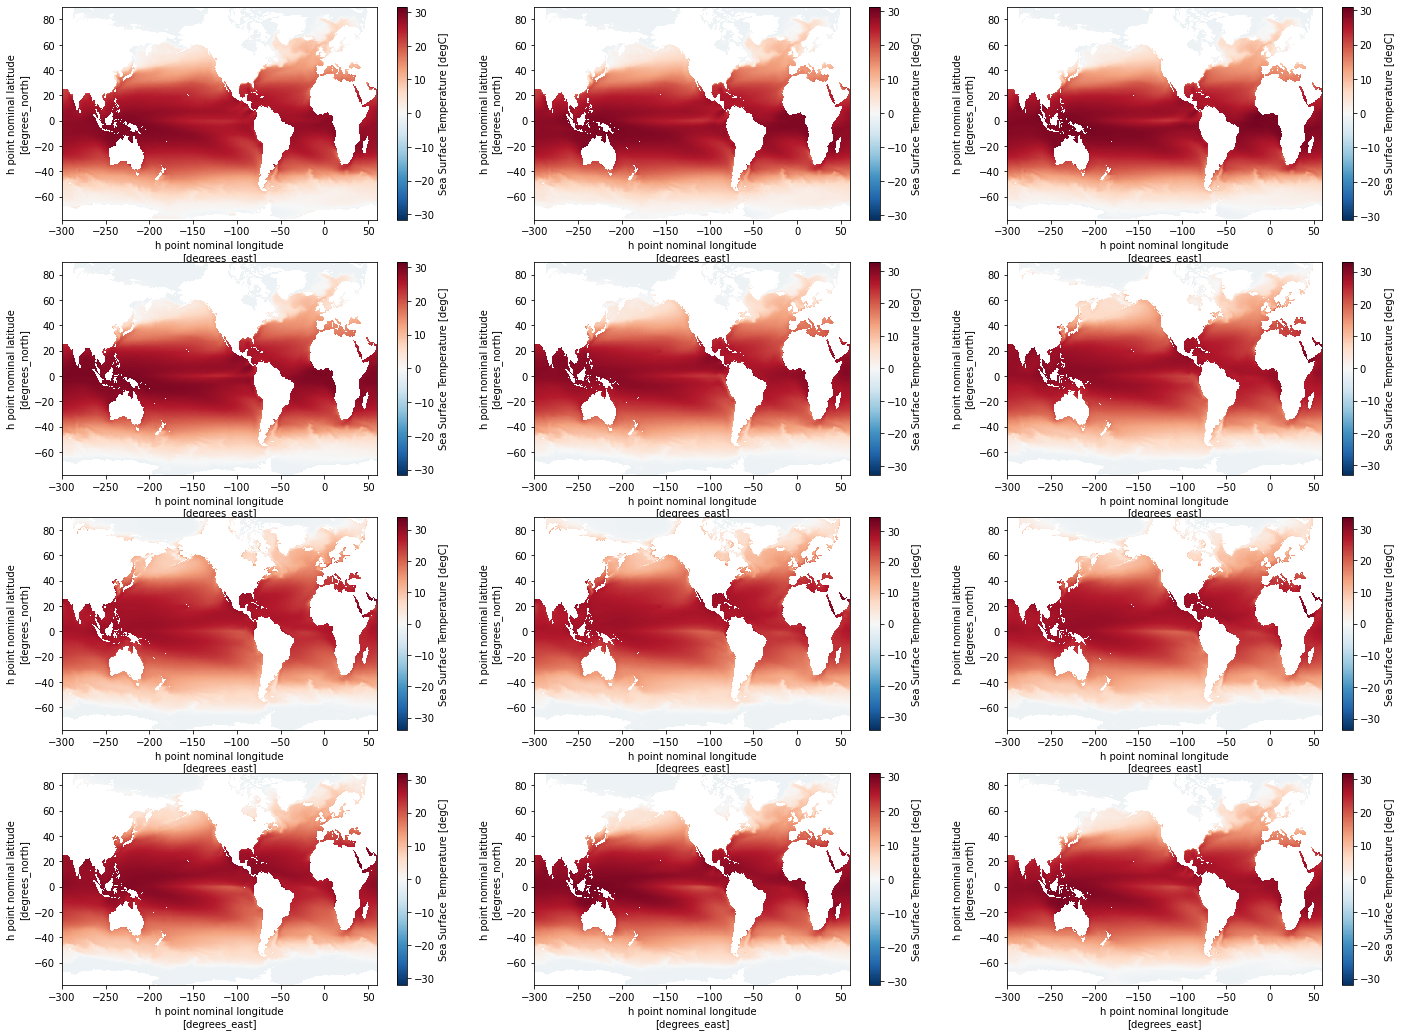

In [34]:
# thing = average or stddev
def plot_gridlayout(averages, name):
    fig = plt.figure(figsize=(24, 18))

    axes = []
    for i in range(12):
        axis = fig.add_subplot(4,3,i+1)
        axes.append(axis)

    for month in range(12):
        averages[month].plot(ax=axes[month])

    plt.savefig(name)
    plt.show()

plot_gridlayout(tss_averages, 'Average_TSS_by_Month_all_300_years')

### View 2: 12 months, individually

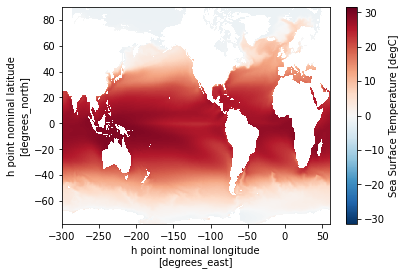

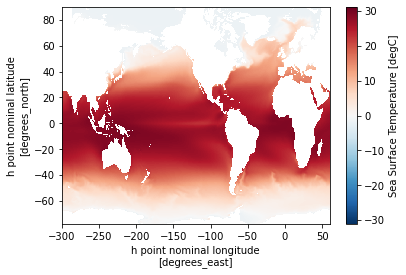

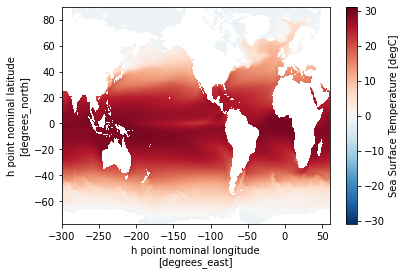

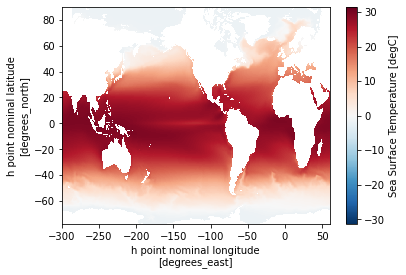

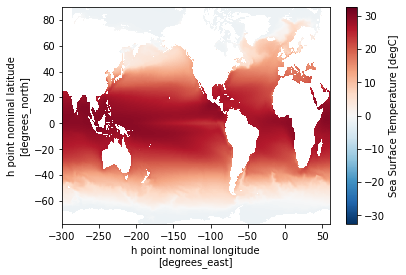

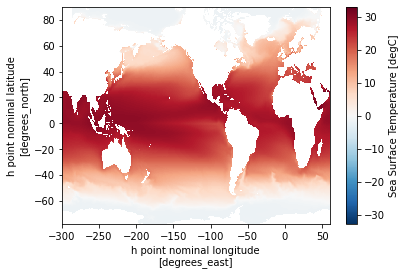

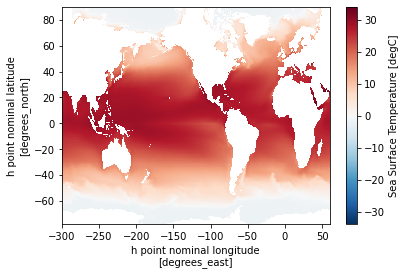

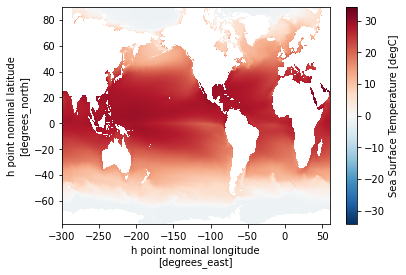

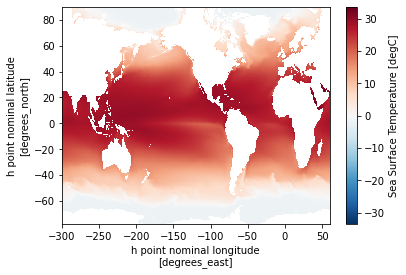

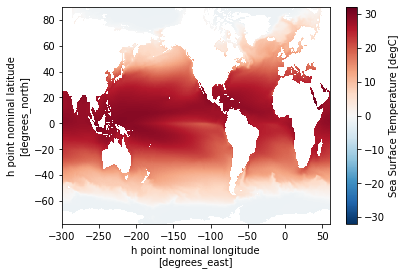

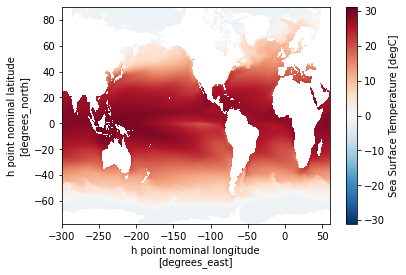

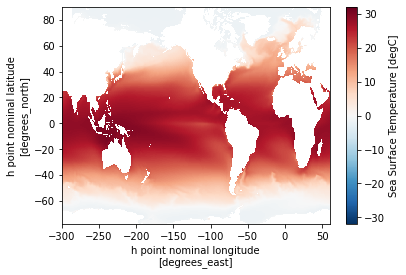

In [35]:
def plot_individually(averages):
    for month in range(12):
        averages[month].plot(size=4)
    
plot_individually(tss_averages)

## Driver 2: Salinity (SSS)

In [36]:
sss_averages = driver_averages(SSS, 'sos')

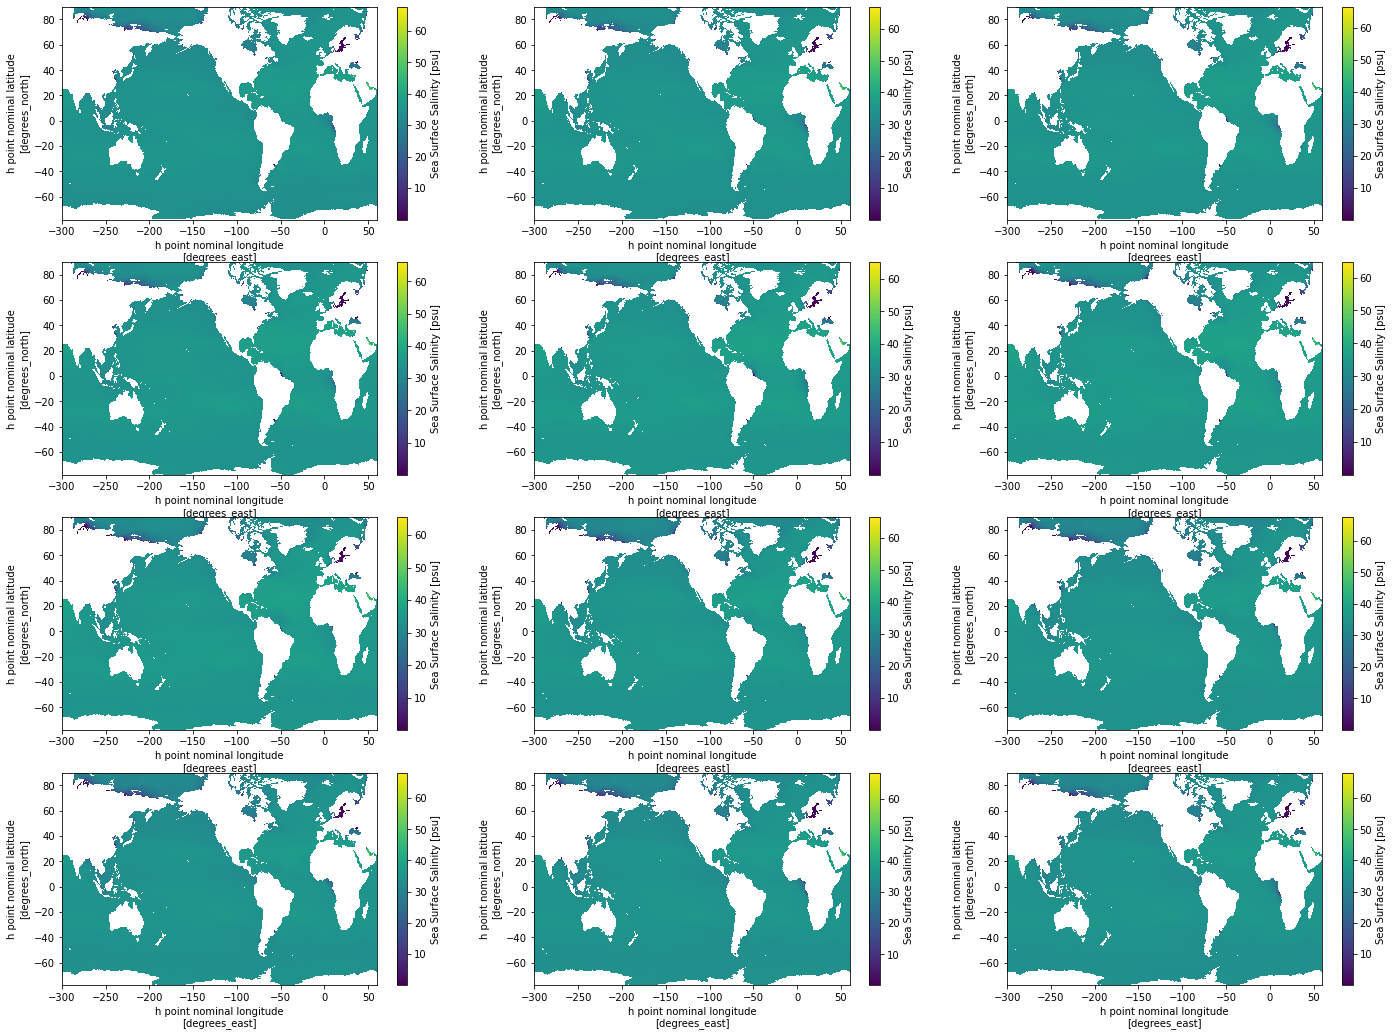

In [37]:
plot_gridlayout(sss_averages,'Average_SSS_Month')

## Part 3: Net Primary Production

First, I am creating just one plot of an arbitrary moment in time to see what it looks like. Note to self: I messed around and it matches the ncview so yay

<xarray.DataArray 'MLD_003' (yh: 576, xh: 720)>
[414720 values with dtype=float32]
Coordinates:
  * xh       (xh) float64 -299.8 -299.2 -298.8 -298.2 ... 58.75 59.25 59.75
  * yh       (yh) float64 -77.91 -77.72 -77.54 -77.36 ... 89.47 89.68 89.89
    time     object 0105-01-16 12:00:00
Attributes:
    long_name:      Mixed layer depth (delta rho = 0.03)
    units:          m
    cell_methods:   area:mean yh:mean xh:mean time: mean
    cell_measures:  area: areacello
    time_avg_info:  average_T1,average_T2,average_DT


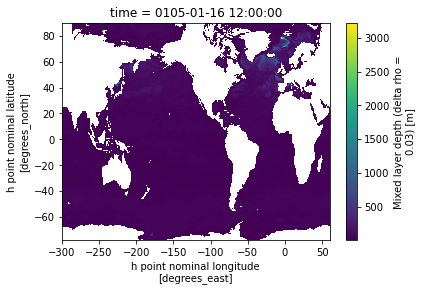

In [38]:
path = MLD[0]
ds = xr.open_dataset(path)
random = ds['MLD_003'].isel(time=48)
print(random)
random.plot()

Now, I'll average all the data and make those plots.

In [39]:
mld_averages = driver_averages(MLD, 'MLD_003')

In [40]:
plot_gridlayout(mld_averages,'Average_MLD_month')

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x14d28c300ee0> (for post_execute):


KeyboardInterrupt: 

In [ ]:
jan = mld_averages[0]
print(jan)
jan.plot()

In [ ]:
print(jan)


In [ ]:
print(random)

In [ ]:
print(jan-random)

In [ ]:
(jan-random).plot()

In [ ]:
difff = jan-random
difff.plot()

In [ ]:
diff_sqr = difff ** 2
diff_sqr.plot()
print(diff_sqr)

--------

# Variance: Standard Deviation of Control

In [ ]:
## CHECK ALL THIS LATER
def get_month_variance_per_file(ds, mon, driver, average):
    # initializing the total
    datapoint = ds[driver].isel(time=mon)
    diff_squared = (average - datapoint) ** 2
    month_total_var = diff_squared
    for i in range(12,60,12):
        datapoint = ds[driver].isel(time=[i+mon])
        diff_squared = (average - datapoint) ** 2
        month_total_var = month_total_var + diff_squared
    return month_total_var

def append_month_variance(ds, mon, month_total_var, driver, average):
    for i in range(0,60,12):
        datapoint = ds[driver].isel(time=[i+mon])
        diff_squared = (average - datapoint) ** 2
        month_total_var = month_total_var + diff_squared
    return month_total_var

In [ ]:
# Test: running get month variance using earlier file 'random'
file_npp_var = get_month_variance_per_file(ds, 2, 'MLD_003', mld_averages[2])
file2 = append_month_variance(ds, 2, file_npp_var, 'MLD_003', mld_averages[2])
print(file_npp_var.equals(file2))
print(file2)
print(file_npp_var)
print(file2.equals(file_npp_var+file2))

In [ ]:
def driver_variances(driver_files, driver, avgs):
    month_var_totals = []
    month_var_averaged = []
    for i in range(len(driver_files)):
        path = driver_files[i]
        ds = xr.open_dataset(path)

        for month in range(12):
            if i==0:
                month_var_totals.append(get_month_variance_per_file(ds, month, driver, avgs[month]))
                print(len(month_var_totals))
            else:
                month_var_totals[month] = append_month_variance(ds, month, month_var_totals[month], driver, avgs[month])
                print(len(month_var_totals))
                
    # at the end, compute the average across all 33 * 5 = 165 months
    for month in range(12):
        month_avg = month_var_totals[month] / (5*len(driver_files))
        if driver=='tos':
            month_avg.attrs["long_name"] = "Sea Surface Temperature"
            month_avg.attrs["units"] = "degC"
        elif driver=='sos':
            month_avg.attrs["long_name"] = "Sea Surface Salinity"
            month_avg.attrs["units"] = "psu"
        elif driver=='MLD_003':
            month_avg.attrs["long_name"] = "Mixed layer depth (delta rho = 0.03)"
            month_avg.attrs["units"] = "m"
        month_var_averaged.append(month_avg)
    return month_var_averaged

In [ ]:
sss_stddev = driver_variances(SSS, 'sos', sss_averages)

In [ ]:
sss_stddev[0].plot()
print(sss_stddev[0])


In [ ]:
print(mld_averages[0])

In [ ]:
plot_gridlayout(sss_stddev,'SSS','Standard_Deviation_of')

In [42]:
rootpath = ('/projects/SOCCOM/data/ESM4_PPE/archive/Richard.Slater/xanadu_esm4_20190304_mom6_ESM4_v1.0.3_rc1/' + 'ESM4_piControl_D/gfdl.ncrc4-intel18-prod-openmp/'+
           'pp/ocean_month/ts/monthly/5yr/')
filename = 'ocean_month.*tos.nc'
tds = xr.open_mfdataset(rootpath+filename)
tds = tds.chunk({'time':60})


In [43]:
tds_jan = tds['tos'].isel(time=slice(0,3600,12))

In [44]:
print(tds_jan)
print(tds)

<xarray.DataArray 'tos' (time: 300, yh: 576, xh: 720)>
dask.array<getitem, shape=(300, 576, 720), dtype=float32, chunksize=(5, 576, 720), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 -299.8 -299.2 -298.8 -298.2 ... 58.75 59.25 59.75
  * yh       (yh) float64 -77.91 -77.72 -77.54 -77.36 ... 89.47 89.68 89.89
  * time     (time) object 0101-01-16 12:00:00 ... 0400-01-16 12:00:00
Attributes:
    long_name:      Sea Surface Temperature
    units:          degC
    cell_methods:   area:mean yh:mean xh:mean time: mean
    cell_measures:  area: areacello
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_surface_temperature
<xarray.Dataset>
Dimensions:    (xh: 720, yh: 576, time: 3600, nv: 2, xq: 720, yq: 576, zl: 75)
Coordinates:
  * xh         (xh) float64 -299.8 -299.2 -298.8 -298.2 ... 58.75 59.25 59.75
  * yh         (yh) float64 -77.91 -77.72 -77.54 -77.36 ... 89.47 89.68 89.89
  * time       (time) object 0101-01-16 12:00:00 ... 0400-12-16 1

<xarray.DataArray 'tos' (time: 300, yh: 576, xh: 720)>
dask.array<getitem, shape=(300, 576, 720), dtype=float32, chunksize=(5, 576, 720), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 -299.8 -299.2 -298.8 -298.2 ... 58.75 59.25 59.75
  * yh       (yh) float64 -77.91 -77.72 -77.54 -77.36 ... 89.47 89.68 89.89
  * time     (time) object 0101-02-15 00:00:00 ... 0400-02-15 00:00:00
Attributes:
    long_name:      Sea Surface Temperature
    units:          degC
    cell_methods:   area:mean yh:mean xh:mean time: mean
    cell_measures:  area: areacello
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_surface_temperature


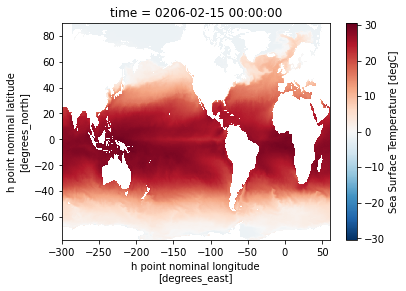

In [45]:
tds_feb = tds['tos'].isel(time=slice(1,3600,12))
print(tds_feb)
tds_feb[105].plot()

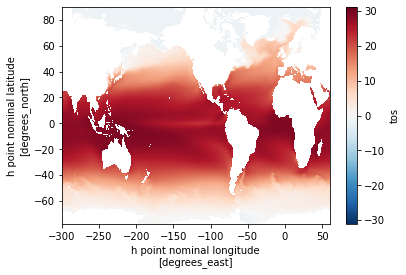

In [46]:
tds_feb_avg = tds_feb.mean(dim='time')
tds_feb_avg.plot()

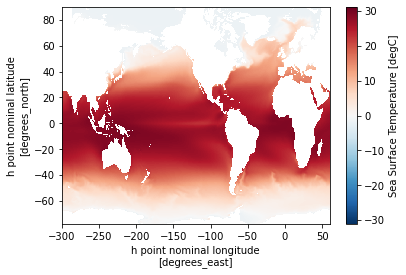

In [47]:
tss_averages[1].plot()

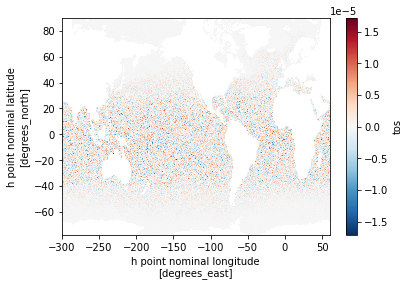

In [48]:
(tds_feb_avg - tss_averages[1]).plot()

In [49]:
print(tds_feb_avg.equals(tss_averages[1]))

False


In [55]:
tstd = tds.std(dim='time')

/home/saumyam/.conda/envs/saumyac/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


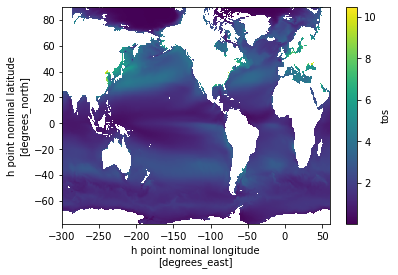

In [56]:
tstd['tos'].plot()

In [57]:
print(tstd)

<xarray.Dataset>
Dimensions:  (xh: 720, yh: 576, nv: 2, xq: 720, yq: 576, zl: 75)
Coordinates:
  * xh       (xh) float64 -299.8 -299.2 -298.8 -298.2 ... 58.75 59.25 59.75
  * yh       (yh) float64 -77.91 -77.72 -77.54 -77.36 ... 89.47 89.68 89.89
  * nv       (nv) float64 1.0 2.0
  * xq       (xq) float64 -299.5 -299.0 -298.5 -298.0 ... 58.5 59.0 59.5 60.0
  * yq       (yq) float64 -77.82 -77.63 -77.45 -77.26 ... 89.37 89.58 89.79 90.0
  * zl       (zl) float64 1.0 3.0 5.0 7.0 ... 3.338e+03 3.591e+03 5.111e+03
Data variables:
    tos      (yh, xh) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>


In [ ]:
# Now plot
# Because this calculation will take a while, it can be useful to ensure that it's still chugging away
# For this we can use a convenient "progress bar"
from dask.diagnostics import ProgressBar

In [ ]:
# loading all the ensemble data

with ProgressBar():
    